In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


# Load Dependencies

In [4]:
# 1. Install system packages
!apt-get update
!apt-get install -y gcc g++

# 2. Install Python libraries equivalent to environment.yml
!pip install numpy matplotlib pillow tqdm pyyaml opencv-python

# 3. Install PyTorch with CUDA 11.8 (compatible with Colab's GPUs)
# Use this if you want GPU acceleration and CUDA
!pip install torch==2.6.0 torchvision==0.21.0


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [6]:
# Install other dependencies
!pip install transformers==4.51.3 accelerate==1.7.0 omegaconf==2.3.0 iopath==0.1.10 \
            huggingface-hub==0.31.4 regex==2024.11.6 portalocker==3.1.1

# Install SAM2 from GitHub
!pip install git+https://github.com/conversation-technology-group/sam2.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 51.4 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=693fcbc3b1bd4ffa09d016fdf29bf9e93dff5db361e6d7fb7aca0a88d6c6322a
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built iopath
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.32.2
    Uninstalling huggingface-hub-0.32.2:
      Successfully uninstalled huggingface-hub-0.32.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3
  Cloning https://github.com/conversation-technology-group/sam2.

In [5]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True


# SAM2 Automatic Mask Generation

## Make directory of images from mp4

Download example_video.mp4 from Zenodo (LINK) and make directory of images

In [ ]:
%mkdir example_video
!ffmpeg -ss 00:00:00 -to 00:00:17 -i "example_video.mp4" -q:v 2 -start_number 0 example_video/'%05d.jpg'

## Utils

In [7]:
import numpy as np
import gc
import matplotlib.pyplot as plt

# Keeps masks based on length filtering
def keep_masks(all_frames_masks, min_len, max_len):
    keep = [
        i for i, m in enumerate(all_frames_masks)
        if min_len < m['bbox'][2] < max_len and min_len < m['bbox'][3] < max_len
    ]
    return [all_frames_masks[j] for j in keep]

# Convert xywh to xyxy bounding boxes
def xywh_to_xyxy(bbox):
    return [int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])]

# Get bounding box from the masks, adding buffer around the mask
def bboxes_from_masks(masks, image_shape, buffer):
    bounding_boxes = []
    for m in masks:
        x_min, y_min, x_max, y_max = xywh_to_xyxy(m['bbox'])
        bounding_boxes.append([
            max(0, x_min - buffer),
            max(0, y_min - buffer),
            min(x_max + buffer, image_shape[1]),
            min(y_max + buffer, image_shape[0])
        ])
    return bounding_boxes

# Get bounding box from mask
def get_bounding_box(mask):
    mask = np.squeeze(mask)
    y_idx, x_idx = np.where(mask)
    if not x_idx.size or not y_idx.size:
        return None
    return np.min(x_idx), np.min(y_idx), np.max(x_idx), np.max(y_idx)

# Calculate iou between two bounding boxes
def calculate_iou(b1, b2):
    xA, yA, xB, yB = max(b1[0], b2[0]), max(b1[1], b2[1]), min(b1[2], b2[2]), min(b1[3], b2[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    union = (b1[2]-b1[0])*(b1[3]-b1[1]) + (b2[2]-b2[0])*(b2[3]-b2[1]) - inter
    return inter / union if union > 0 else 0


In [8]:
import torch
from sam2.build_sam import build_sam2_video_predictor, build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import os
import urllib.request

# Download SAM2 checkpoint (SAM2 Large)
def download_checkpoint_if_missing(checkpoint_path):
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if not os.path.exists(checkpoint_path):
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        print(f"Downloading SAM2 checkpoint to {checkpoint_path}...")
        url = "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"
        urllib.request.urlretrieve(url, checkpoint_path)
        print("Download complete.")

# Setup and load device (runs faster on GPU - cuda)
def setup_device(preference='auto'):
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if preference == 'auto':
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.backends.mps.is_available():
            return torch.device("mps")
    return torch.device("cpu")

# Building SAM2 Video Predictor
def load_sam_predictor(device):
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    checkpoint_path = checkpoint
    download_checkpoint_if_missing(checkpoint_path)
    predictor = build_sam2_video_predictor(
        model_cfg,
        checkpoint,
        device=device,
        vos_optimized=vos_optimized
    )
    return predictor

# Building SAM2 Automatic Mask Generator from specific parameters
def load_mask_generator(device):
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    sam = build_sam2(
        model_cfg,
        checkpoint,
        device=device,
        apply_postprocessing=False
    )
    return SAM2AutomaticMaskGenerator(model=sam,
                                        points_per_side = points_per_side,
                                        points_per_batch = points_per_batch,
                                        pred_iou_thresh = pred_iou_thresh,
                                        stability_score_thresh = stability_score_thresh,
                                        stability_score_offset = stability_score_offset,
                                        crop_n_layers = crop_n_layers,
                                        box_nms_thresh = box_nms_thresh,
                                        crop_nms_thresh = crop_nms_thresh,
                                        crop_n_points_downscale_factor = crop_n_points_downscale_factor,
                                        min_mask_region_area = min_mask_region_area,
                                        use_m2m = False
                                      )


## Mask Generation

In [9]:
# Paths
video_dir = "example_video"
output_txt = "keep_boxes_example_video.txt"

# SAM2
model_cfg = "sam2_hiera_l.yaml"
checkpoint = "checkpoints/sam2_hiera_large.pt"
device_pref = "auto"
vos_optimized = False # Can change this to True if on an appropriate GPU

# Mask Generator Parameters
points_per_side = 32
points_per_batch = 32
pred_iou_thresh = 0.7
stability_score_thresh = 0.92
stability_score_offset = 0.7
crop_n_layers = 1
box_nms_thresh = 0.3
crop_nms_thresh = 0.3
crop_n_points_downscale_factor = 2
min_mask_region_area = 0
use_m2m = False

# General Parameters
run_every_n_frames = 30 # Run SAM2 Automatic Mask Generation every __ frames


In [12]:
import os
import yaml
import gc
import pickle
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import torchvision


print("Torch is cuda available:", torch.cuda.is_available())
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

device = setup_device(device_pref)
print("Using device:", device)

# Load SAM2
predictor = load_sam_predictor(device)
mask_generator = load_mask_generator(device)

Torch is cuda available: True
Using device: cuda


In [13]:
# === Prepare video frames ===
frame_gap = run_every_n_frames
frame_names = sorted([
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
], key=lambda p: int(os.path.splitext(p)[0]))

images = [
    np.array(Image.open(os.path.join(video_dir, frame_names[i])).convert("RGB"))
    for i in range(0, len(frame_names), frame_gap)
]


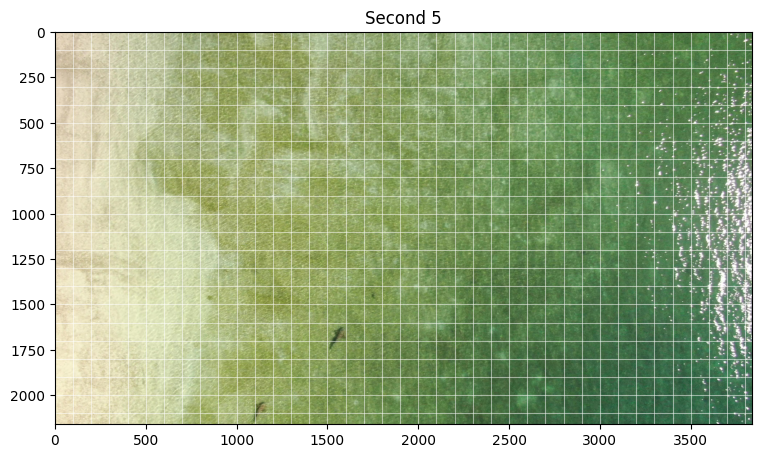

11892

In [14]:
# Show the first frame with a transparent grid every 100 pixels
second = 5
plt.figure(figsize=(9, 6))
plt.title(f"Second {second}")
plt.imshow(images[second])

# Get image dimensions
height, width = images[0].shape[:2]

# Add vertical grid lines
for x in range(0, width, 100):
    plt.axvline(x=x, color='white', linewidth=0.8, alpha=0.5)

# Add horizontal grid lines
for y in range(0, height, 100):
    plt.axhline(y=y, color='white', linewidth=0.8, alpha=0.5)

plt.show()
gc.collect()


Estimate minimum and maximum mask size from gridded visualization above (fits within a n x n box). If uncertain, set minimum to 0 and maximum to estimated max

In [15]:
min_mask_length = 50 # Minimum mask size (calibrate to your task)
max_mask_length = 150 # Maximum mask size (calibrate to your task)
bbox_buffer = 25 # Padding around bounding box

Running SAM2 Automatic Mask Generation and generating candidate masks for each image

In [16]:
# === Mask generation + bounding boxes ===
all_frames_bboxes = []
for i, img in enumerate(tqdm(images)):
    masks = mask_generator.generate(img)
    masks = keep_masks(masks, min_mask_length, max_mask_length)
    boxes = bboxes_from_masks(masks, img.shape, bbox_buffer)
    all_frames_bboxes.append(boxes)
    torch.cuda.empty_cache()

100%|██████████| 17/17 [04:15<00:00, 15.00s/it]


# CLIP

In [17]:
### Load CLIP Model
from transformers import CLIPProcessor, CLIPModel

def load_clip_model():
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=False)
    return processor, model

clip_processor, clip_model = load_clip_model()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Set CLIP prompts here! Some manual prompt tuning may be necessary

In [18]:
clip_confidence = 0.95 # Confidence threshold for CLIP filtering

# CLIP Prompts
clip_prompts = [
    "A drone image of white shape on surface of the ocean",
    "A clear zoomed-in drone image of a complete dark nurse shark in the ocean with distinct pectoral fins and tail",
    "A drone image of the ocean with no distinct sharks",
    "A drone image of a rock under the surface of the ocean with no sharks",
    "A drone image of sand in the ocean",
    "A drone image of rocks on land",
]

clip_correct = [1] # Indices of the correct prompts from clip_prompts (the prompts for the objects you want to identify)


Second 2


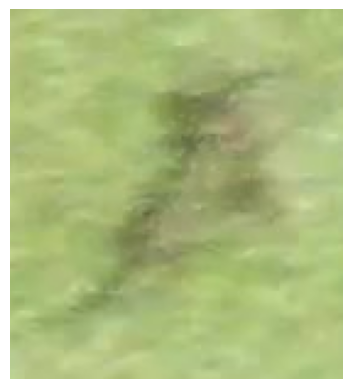

Second 3


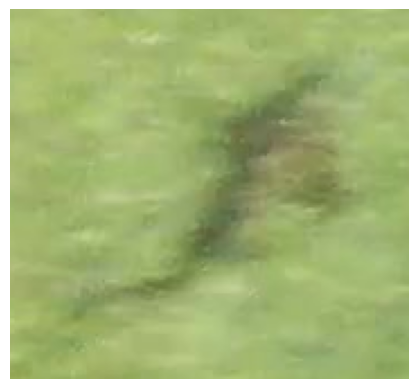

Second 4


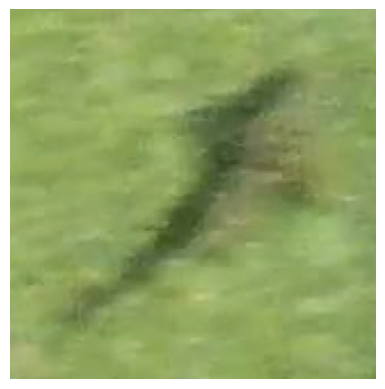

Second 5


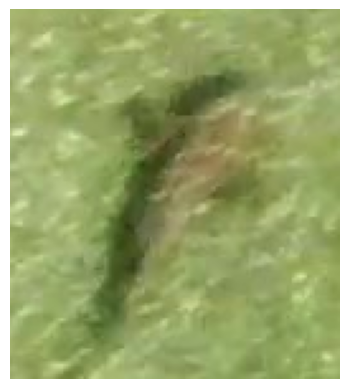

Second 6


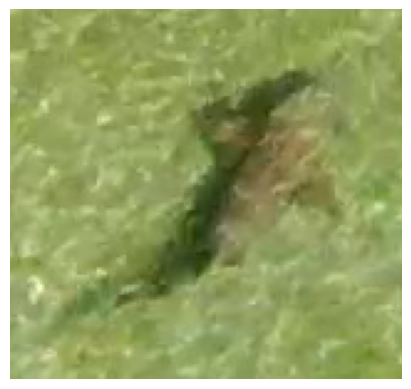

Second 8


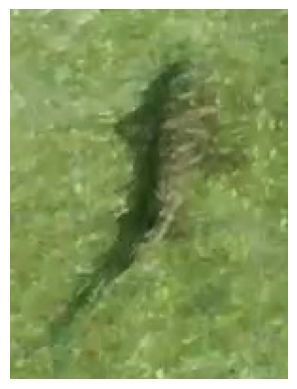

Second 9


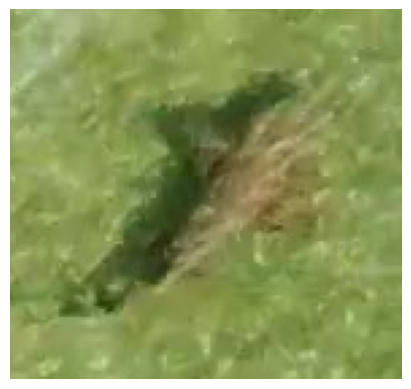

Second 11


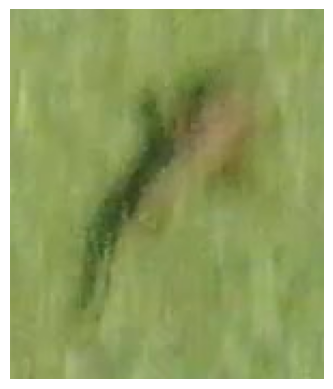

Second 12


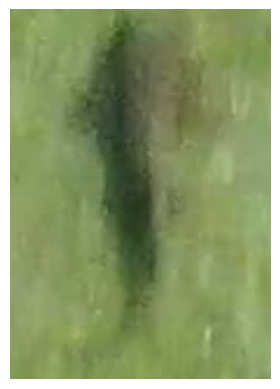

Second 13


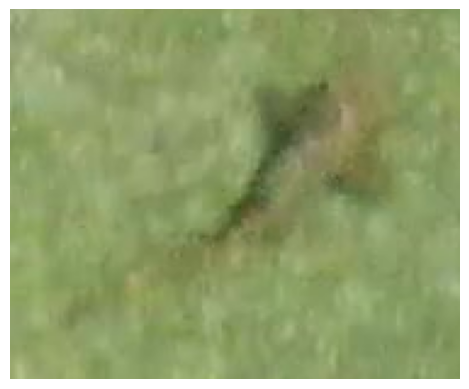

Second 14


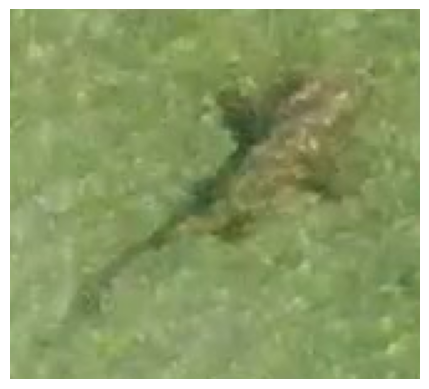

Second 15


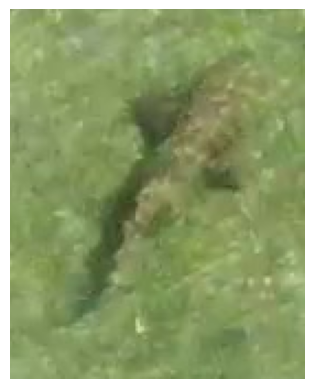

Second 16


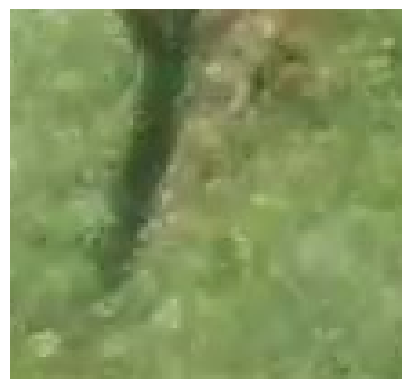

Saved 13 boxes to keep_boxes_example_video.txt


In [19]:
# === CLIP filtering ===
keep_boxes = []
prompts = clip_prompts

for i, (img, bboxes) in enumerate(zip(images, all_frames_bboxes)):
    crops = [img[y1:y2+1, x1:x2+1] for x1, y1, x2, y2 in bboxes]
    if not crops: continue

    inputs = clip_processor(text=prompts, images=crops, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    probs = outputs["logits_per_image"].softmax(dim=1).detach().numpy()

    shark_probs = [p[clip_correct] for p in probs]
    for j, probs in enumerate(shark_probs):
        for prob in probs:
          if prob > clip_confidence:
              keep_boxes.append((i, j, bboxes[j]))

              # Display the cropped image
              print("Second", i)
              plt.imshow(crops[j])
              plt.axis('off')  # Hide the axes
              plt.show()
              plt.close()
              gc.collect()

# === Save to .txt ===
txt_out = output_txt
with open(txt_out, "w") as f:
    for i, j, bbox in keep_boxes:
        f.write(f"{i},{j},{','.join(map(str, bbox))}\n")

print(f"Saved {len(keep_boxes)} boxes to {txt_out}")

# === Reorganize to frame_keep_boxes ===
frame_keep_boxes = [[] for _ in range(len(images))]
for i, j, bbox in keep_boxes:
    frame_keep_boxes[i].append((i, j, bbox))

# SAM2 Video Propagation + Frame Alignment

In [20]:
# === Run tracking and propagation ===
print("Setting inference state...")
image = np.array(Image.open(os.path.join(video_dir, frame_names[0])).convert("RGB"))
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    inference_state = predictor.init_state(video_path=video_dir, async_loading_frames=True)

Setting inference state...


Set output directories and window length. A larger window length may capture more true positives but takes longer to run

In [21]:
output_dir_prefix = "video_segments_example_video"

window_length = 3 # Window length for propagation

# Parameters for visualization of masks before pruning
n_per_mask = 9 # Plotting 3x3 images every mask
resize_factor = 0.3 # Resizing images to fit page

## Utils

In [23]:
import os
import gc
import time
import numpy as np
from collections import defaultdict
import torch
import torchvision

def run_propagation(
    predictor,
    inference_state,
    frame_keep_boxes,
    frame_names,
    video_dir,
    image_shape,
    frame_gap,
    window_length,
    output_dir,
    bbox_buffer
):
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    os.makedirs(output_dir, exist_ok=True)
    start_time = time.time()
    curr_id = 0
    correct = []
    frames = []
    repropagate = []

    for a in range(len(frame_keep_boxes)):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        print(f"\nSecond: {a}")

        if curr_id == 0:
            predictor.reset_state(inference_state)
            for b in range(len(frame_keep_boxes[a])):
                curr_id += 1
                i, j, bbox = frame_keep_boxes[a][b]
                _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                    inference_state=inference_state,
                    frame_idx=i * frame_gap,
                    obj_id=curr_id,
                    box=bbox,
                )
                correct.append(False)
                frames.append(i)
                repropagate.append(i + window_length)
            if curr_id != 0:
                _propagate(
                    predictor,
                    inference_state,
                    output_dir,
                    start=max(0, frame_gap * (a - window_length)),
                    max_frame=(frame_gap * window_length) + (frame_gap * a - max(0, frame_gap * (a - window_length))),
                    image_shape=image_shape,
                )

        else:
            prev_curr_id = curr_id
            predictor.reset_state(inference_state)

            for b in range(len(frame_keep_boxes[a])):
                i, j, bbox = frame_keep_boxes[a][b]
                filename = os.path.join(output_dir, f'frame_{i * frame_gap}.npy')
                mask_add = True

                if os.path.exists(filename):
                    frame_segments = np.load(filename, allow_pickle=True).item()
                    for key in sorted(frame_segments.keys(), key=int):
                        bounding_box = get_bounding_box(frame_segments[key])
                        if bounding_box is not None:
                            bounding_box = [
                                max(0, bounding_box[0] - bbox_buffer),
                                max(0, bounding_box[1] - bbox_buffer),
                                min(bounding_box[2] + bbox_buffer, image_shape[1]),
                                min(bounding_box[3] + bbox_buffer, image_shape[0])
                            ]
                            iou = calculate_iou(bbox, bounding_box)
                            if iou > 0.7:
                                print("Duplicate mask!")
                                mask_add = False
                                if i != frames[int(key) - 1]:
                                    correct[int(key) - 1] = True
                                break
                    del frame_segments

                if mask_add:
                    curr_id += 1
                    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                        inference_state=inference_state,
                        frame_idx=i * frame_gap,
                        obj_id=curr_id,
                        box=bbox,
                    )
                    correct.append(False)
                    frames.append(i)
                    repropagate.append(i + window_length)

            if prev_curr_id != curr_id:
                _propagate(
                    predictor,
                    inference_state,
                    output_dir,
                    start=max(0, frame_gap * (a - window_length)),
                    max_frame=(frame_gap * window_length) + (frame_gap * a - max(0, frame_gap * (a - window_length))),
                    image_shape=image_shape,
                )

        # Repropagate if necessary
        indices = [i for i, x in enumerate(repropagate) if x == a]
        should_reprop = False
        predictor.reset_state(inference_state)

        for index in indices:
            if correct[index]:
                filename = os.path.join(output_dir, f'frame_{(frame_gap * a) - 1}.npy')
                frame_segments_old = np.load(filename, allow_pickle=True).item()
                bounding_box = get_bounding_box(frame_segments_old.get(index + 1))
                del frame_segments_old

                if bounding_box is not None:
                    should_reprop = True
                    print("Re-propagating index", index, "at second", a)
                    bounding_box = [
                        max(0, bounding_box[0] - bbox_buffer),
                        max(0, bounding_box[1] - bbox_buffer),
                        min(bounding_box[2] + bbox_buffer, image_shape[1]),
                        min(bounding_box[3] + bbox_buffer, image_shape[0])
                    ]

                    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                        inference_state=inference_state,
                        frame_idx=(frame_gap * a),
                        obj_id=index + 1,
                        box=bounding_box,
                    )
                    repropagate[index] += window_length

        if should_reprop:
            _propagate(
                predictor,
                inference_state,
                output_dir,
                start=frame_gap * a,
                max_frame=frame_gap * window_length,
                image_shape=image_shape,
            )

    # Filter final masks
    correct_indices = [i + 1 for i, is_correct in enumerate(correct) if is_correct]

    # Wrap the loop with tqdm for progress bar
    for i, fname in enumerate(tqdm(os.listdir(output_dir), desc="Filtering files")):
        fpath = os.path.join(output_dir, fname)
        data = np.load(fpath, allow_pickle=True).item()
        filtered = {k: v for k, v in data.items() if int(k) in correct_indices}
        np.save(fpath, filtered)

    print(f"Window {window_length} took {time.time() - start_time:.2f} seconds")


def _propagate(predictor, inference_state, output_dir, start, max_frame, image_shape):
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    all_results = defaultdict(dict)
    with torch.autocast("cuda", torch.bfloat16):
        with torch.inference_mode():
            iterator = predictor.propagate_in_video(
                inference_state,
                start_frame_idx=start,
                max_frame_num_to_track=max_frame
            )
            for out_frame_idx, out_obj_ids, out_mask_logits in iterator:
                frame_segments = {
                    out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                    for i, out_obj_id in enumerate(out_obj_ids)
                }
                all_results[out_frame_idx].update(frame_segments)
                del frame_segments, out_obj_ids, out_mask_logits

    for out_frame_idx, new_segments in all_results.items():
        file_path = os.path.join(output_dir, f'frame_{out_frame_idx}.npy')
        try:
            old_segments = np.load(file_path, allow_pickle=True).item()
            old_segments.update(new_segments)
            np.save(file_path, old_segments)
            del old_segments
        except FileNotFoundError:
            np.save(file_path, new_segments)
        del new_segments


In [24]:
import os
import gc
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages

def get_bounding_box(mask):
    mask = np.squeeze(mask)
    y_indices, x_indices = np.where(mask)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None
    return (np.min(x_indices), np.min(y_indices), np.max(x_indices), np.max(y_indices))

import os
import random
import gc
from collections import defaultdict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, HTML

def display_mask_grid(n_per_mask, resize_factor, mask_dir, video_dir):
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    all_samples = defaultdict(list)
    for fname in tqdm(os.listdir(mask_dir), desc="Indexing masks"):
        if not fname.endswith(".npy"):
            continue
        frame_index = int(fname.split("_")[1].split(".")[0])
        fpath = os.path.join(mask_dir, fname)
        data = np.load(fpath, allow_pickle=True).item()
        for mask_num, mask in data.items():
            bbox = get_bounding_box(mask)
            if bbox is not None:
                all_samples[mask_num].append((frame_index, mask, bbox))
        del data
        gc.collect()

    for mask_num, samples in all_samples.items():
        if len(samples) < n_per_mask:
            continue
        selected = random.sample(samples, n_per_mask)
        frame_indices = [f for f, _, _ in samples]

        fig, axes = plt.subplots(3, 3, figsize=(12, 9))
        axes = axes.flatten()
        for ax, (frame_index, mask, bbox) in zip(axes, selected):
            img_path = os.path.join(video_dir, frame_names[frame_index])
            image = Image.open(img_path).convert("RGB")
            if resize_factor != 1.0:
                image = image.resize(
                    (int(image.width * resize_factor), int(image.height * resize_factor))
                )
                scale = resize_factor
            else:
                scale = 1.0
            img_np = np.array(image)
            bbox_scaled = tuple(int(c * scale) for c in bbox)

            pad = 5
            x_min = max(bbox_scaled[0] - pad, 0)
            y_min = max(bbox_scaled[1] - pad, 0)
            x_max = min(bbox_scaled[2] + pad, img_np.shape[1])
            y_max = min(bbox_scaled[3] + pad, img_np.shape[0])

            ax.imshow(img_np)
            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)
            ax.set_title(f"Frame {frame_index}")
            ax.axis("off")
            del image, img_np

        earliest = min(frame_indices)
        latest = max(frame_indices)
        fig.suptitle(f"Mask #{mask_num} | Frames {earliest}–{latest}", fontsize=14)
        plt.tight_layout()
        plt.show()
        gc.collect()



## Propagate

In [25]:

run_propagation(
    predictor=predictor,
    inference_state=inference_state,
    frame_keep_boxes=frame_keep_boxes,
    frame_names=frame_names,
    video_dir=video_dir,
    image_shape=image.shape,
    frame_gap=frame_gap,
    window_length=window_length,
    output_dir=output_dir_prefix,
    bbox_buffer=bbox_buffer
)

generate_mask_grid(
    n_per_mask=n_per_mask,
    resize_factor=resize_factor,
    mask_dir=output_dir_prefix,
    video_dir=video_dir,
    output_pdf_path=output_pdf_path
)





Second: 0

Second: 1

Second: 2


/usr/local/lib/python3.11/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: /usr/local/lib/python3.11/dist-packages/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 151/151 [01:03<00:00,  2.37it/s]



Second: 3
Duplicate mask!

Second: 4
Duplicate mask!

Second: 5


propagate in video: 100%|██████████| 181/181 [01:05<00:00,  2.77it/s]


Re-propagating index 0 at second 5


propagate in video: 100%|██████████| 91/91 [00:29<00:00,  3.10it/s]



Second: 6
Duplicate mask!

Second: 7

Second: 8
Duplicate mask!
Re-propagating index 0 at second 8
Re-propagating index 1 at second 8


propagate in video: 100%|██████████| 91/91 [00:46<00:00,  1.97it/s]



Second: 9
Duplicate mask!

Second: 10

Second: 11
Duplicate mask!
Re-propagating index 0 at second 11
Re-propagating index 1 at second 11


propagate in video: 100%|██████████| 91/91 [00:40<00:00,  2.27it/s]



Second: 12
Duplicate mask!

Second: 13


propagate in video: 100%|██████████| 181/181 [00:58<00:00,  3.07it/s]



Second: 14
Duplicate mask!
Re-propagating index 1 at second 14


propagate in video: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]



Second: 15
Duplicate mask!

Second: 16
Duplicate mask!


Filtering files: 100%|██████████| 510/510 [00:53<00:00,  9.46it/s]


Window 3 took 472.42 seconds


Indexing masks: 100%|██████████| 510/510 [03:27<00:00,  2.46it/s]


# Manual Mask Pruning

Optional manual mask pruning. Set the output directory and the keys to keep from the visual output of SAM2 Video Propagation

In [29]:
pruned_output_dir = "video_segments_example_video_pruned"
keep_keys = [1, 2]

In [30]:
keep_keys = set(keep_keys)  # use a set for faster lookup

os.makedirs(pruned_output_dir, exist_ok=True)

for fname in tqdm(os.listdir(output_dir_prefix), desc="Filtering mask files"):
    if not fname.endswith(".npy"):
        continue

    fpath = os.path.join(output_dir_prefix, fname)
    data = np.load(fpath, allow_pickle=True).item()

    filtered = {k: v for k, v in data.items() if k in keep_keys}

    outpath = os.path.join(pruned_output_dir, fname)
    np.save(outpath, filtered)

    del data, filtered

gc.collect()


Filtering mask files: 100%|██████████| 510/510 [00:41<00:00, 12.36it/s]


41370

# Visualization

## Overlay masks on images

In [31]:
# Output directory paths
output_overlaid_frames_dir = "tracked_example_video"
output_video = "tracked_example_video.mp4"


In [32]:
import cv2

os.makedirs(output_overlaid_frames_dir, exist_ok=True)

# Define min and max frames (update as needed)
min_frame = 0
max_frame = len(frame_names) - 1

# Define a list of colors (BGR format)
colors = [
    (0, 0, 255),     # Red
    (0, 255, 0),     # Green
    (255, 0, 255),   # Magenta
    (255, 0, 0),     # Blue
    (0, 255, 255),   # Yellow
    (255, 165, 0),   # Orange
    (128, 0, 128)    # Purple
]

mask_colors = dict(zip(keep_keys, colors[:len(keep_keys)]))


def save_frame_with_masks_cv2(frame_path, masks, output_path):
    """
    Overlay each mask in a different color on the frame and save using OpenCV.
    """
    image = cv2.imread(frame_path)

    for i in masks.keys():
        mask = masks[i]
        color = mask_colors[i]
        red_overlay = np.zeros_like(image, dtype=np.uint8)

        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask[0]
        elif mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask[..., 0]

        mask = mask.astype(bool)
        red_overlay[mask] = color
        image = cv2.addWeighted(image, 1.0, red_overlay, 0.4, 0)

    cv2.imwrite(output_path, image)

In [33]:
# Loop through frames with tqdm progress bar
for frame_idx in tqdm(range(min_frame, max_frame + 1), desc="Processing frames"):
    mask_path = os.path.join(pruned_output_dir, f'frame_{frame_idx}.npy')
    masks = {}

    if os.path.exists(mask_path):
        masks = np.load(mask_path, allow_pickle=True).item()

    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    output_path = os.path.join(output_overlaid_frames_dir, f'{frame_idx:05d}.jpg')

    save_frame_with_masks_cv2(frame_path, masks, output_path)

    if frame_idx % 100 == 0:
        gc.collect()


Processing frames: 100%|██████████| 510/510 [01:28<00:00,  5.73it/s]


## Convert to video

Convert directory of images to an mp4 for easy visualization

In [34]:
!ffmpeg -framerate 30 -pattern_type glob -i '{output_overlaid_frames_dir}/*.jpg' \
-vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -c:v libx264 -pix_fmt yuv420p {output_video}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab